In [24]:
import time
import pandas as pd
import numpy as np
import geopandas as gd
from shapely.geometry import Point, box
from collections import defaultdict
from numpy import nan
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import os
os.chdir(r"E:\Data challenge")

# Importing Data

In [25]:
#data_drias = pd.read_csv(r"data\Drias_data\RCP_2.6.csv", sep=";", header=31)
#data_drias = pd.read_csv(r"data\Drias_data\RCP_4.5.csv", sep=";", header=31)
#data_drias = pd.read_csv(r"data\Drias_data\RCP_8.5.csv", sep=";", header=31)

#data_drias = pd.read_csv(r"data\Drias_data\RCP_2.6_with_distance.csv", sep=";")
#data_drias = pd.read_csv(r"data\Drias_data\RCP_4.5_with_distance.csv", sep=";")
data_drias = pd.read_csv(r"data\Drias_data\RCP_8.5_with_distance.csv", sep=";")

scenario = data_drias.Contexte[0]

In [26]:
data_drias

,Point,Latitude,Longitude,Contexte,Période,NORPAV,NORRR,NORRR1MM,NORPN20MM,NORPFL90,...,NORPINT,NORPQ90,NORPQ99,NORRR99,NORHUSAV,NORETPC,Unnamed: 17,dist_fleuve_km,dist_riviere_km,dist_cote_km
0,139,41.3373,9.1495,RCP8.5,H1,1.81,664.12,78.92,7,81.30,...,8.16,5.06,27.02,3.71,9.34,1069.29,NaN,49.508247,5.648592,3.955963
1,281,41.4149,9.0628,RCP8.5,H1,1.82,664.63,79.39,7,81.27,...,8.23,5.07,26.73,3.96,9.34,1074.48,NaN,38.326724,5.089265,2.651321
2,282,41.4087,9.1577,RCP8.5,H1,1.89,689.14,80.52,7,81.07,...,8.43,5.25,28.36,4.07,9.14,1047.82,NaN,43.462308,0.538889,1.831904
3,283,41.4025,9.2527,RCP8.5,H1,1.83,668.06,79.92,7,81.15,...,8.29,5.13,27.43,4.10,9.30,1066.50,NaN,49.359392,1.719596,0.168025
4,422,41.4985,8.8808,RCP8.5,H1,1.86,680.06,79.02,7,81.49,...,8.35,5.02,26.93,4.00,9.29,1055.45,NaN,24.003419,2.192640,0.674574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26938,18942,51.0496,2.1658,RCP8.5,H3,2.12,773.31,120.73,5,63.84,...,6.31,6.68,21.53,5.94,8.36,692.33,NaN,6.273270,8.233442,0.588727
26939,18943,51.0497,2.2796,RCP8.5,H3,2.16,787.81,119.71,5,63.88,...,6.38,6.75,21.70,6.28,8.35,689.52,NaN,12.872273,12.739722,0.078175
26940,18944,51.0497,2.3934,RCP8.5,H3,2.16,788.10,120.92,5,63.88,...,6.38,6.75,21.71,6.28,8.35,689.44,NaN,17.257527,17.312641,0.098655
26941,18945,51.0496,2.5071,RCP8.5,H3,2.16,787.40,121.10,5,63.95,...,6.39,6.83,21.73,6.24,8.35,686.99,NaN,15.745569,17.415665,2.838772


In [27]:
data_clay = gd.read_file(r"data\Flood\clay_risk_results.csv")
data_clay = data_clay.astype({'longitude': 'Float64', 'latitude': 'Float64'})

# Preparing Data Flood

We turn our categorical data into numerical value, treat Nan and join our data_clay and data_drias spatially

In [28]:
data_clay["alea"] = data_clay["alea"].replace({"Faible": 1,"Moyen": 2,"Fort": 3})
data_clay.drop(columns=['niveau'],inplace=True)
data_clay["alea"] = data_clay["alea"].replace("", pd.NA)
data_clay["alea"] = data_clay["alea"].fillna(0)
data_clay = data_clay.astype({'alea': 'int32'})

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9352\2279142045.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clay["alea"] = data_clay["alea"].fillna(0)


In [29]:
import geopandas as gpd
from shapely.geometry import Point

gdf1 = gpd.GeoDataFrame(data_drias, geometry=gpd.points_from_xy(data_drias.Longitude, data_drias.Latitude), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(data_clay, geometry=gpd.points_from_xy(data_clay.longitude, data_clay.latitude), crs="EPSG:4326")

gdf1 = gdf1.to_crs(3857)
gdf2 = gdf2.to_crs(3857)

data_merged = gpd.sjoin_nearest(gdf1,gdf2.drop(columns=['latitude','longitude']),max_distance=50,distance_col="distance_m")

In [30]:
data_merged.drop(columns=['Unnamed: 17','Point','Contexte','field_1','distance_m','index_right','geometry'], inplace=True)

# MODEL

We import our model, predict our **classes of risk** and our **expected height** for the flood.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.preprocessing import StandardScaler

df = data_merged.copy()

In [32]:
input_size = 17
num_classes_min = 5
num_classes_max = 1001

In [33]:
class DenseNetClassifier(nn.Module):
    def __init__(self, input_dim, num_classes_min, num_classes_max):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
        )
        self.ht_min = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes_min)
        )
        self.ht_max = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes_max)
        )

    def forward(self, x):
        #base = self.net(x)
        return self.ht_min(x), self.ht_max(x)

In [34]:
model_ht = DenseNetClassifier(input_size, num_classes_min, num_classes_max)


In [35]:
import joblib
rf = joblib.load(r"model\random_forest_model.pkl")
hgb = joblib.load(r"model\HistGradientBoostingClassifier_model.pkl")
scaler = joblib.load(r"model\ht_scaler.pkl")
model_ht.load_state_dict(torch.load(r'model\model_ht_state.pth'))

<All keys matched successfully>

In [36]:
import pandas as pd

importances = rf.feature_importances_

# if you know feature names
feature_names = rf.feature_names_in_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(importance_df)

            feature  importance
12   dist_fleuve_km    0.114861
14     dist_cote_km    0.095674
11          NORETPC    0.080106
7           NORPQ90    0.076675
2          NORRR1MM    0.075480
10         NORHUSAV    0.075048
1             NORRR    0.065529
4          NORPFL90    0.064362
13  dist_riviere_km    0.062777
8           NORPQ99    0.060174
6           NORPINT    0.054768
9           NORRR99    0.053447
0            NORPAV    0.046853
5          NORPXCDD    0.035502
15             alea    0.021724
3         NORPN20MM    0.017017


In [37]:
scale_col = ['NORPAV', 'NORRR', 'NORRR1MM', 'NORPN20MM', 'NORPFL90',
       'NORPXCDD', 'NORPINT', 'NORPQ90', 'NORPQ99', 'NORRR99', 'NORHUSAV',
       'NORETPC','dist_fleuve_km','dist_riviere_km','dist_cote_km']

In [38]:
feature_order = ['Flood_risk','NORPAV','NORRR','NORRR1MM',
    'NORPN20MM','NORPFL90','NORPXCDD','NORPINT','NORPQ90',
    'NORPQ99','NORRR99','NORHUSAV','NORETPC','dist_fleuve_km','dist_riviere_km','dist_cote_km','alea']


In [39]:
def prep_data(data):
    df = data.copy()
    periode = df["Période"]
    latitude, longitude = df['Latitude'], df['Longitude']
    X = df.drop(columns=['Période','Longitude','Latitude'])
    X = X.select_dtypes(include=["int32","int64","float64"])
    return X, periode, latitude, longitude

In [40]:
def create_results(data, model_class, model_ht):
    #remove period from data
    df, periode, latitude, longitude = prep_data(data)

    #pred class of risk
    pred_class = model_class.predict(df)
    df['Flood_risk'] = pred_class
    print(df['Flood_risk'].value_counts())

    #scale
    df[scale_col] = scaler.transform(df[scale_col])

    #order columns
    df = df[feature_order]

    #pred ht
    df_for_ht = torch.tensor(df.to_numpy(), dtype=torch.float32)
    model_ht.eval()
    with torch.no_grad():
        ht_min_prob, ht_max_prob = model_ht(df_for_ht)
        ht_min_prob, ht_max_prob = model_ht(df_for_ht)
        ht_min_pred = torch.argmax(ht_min_prob, dim=1)
        ht_max_pred = torch.argmax(ht_max_prob, dim=1)

    #create dataframe
    df['ht_min'] = ht_min_pred
    df['ht_max'] = ht_max_pred
    df['Période'] = periode
    df['longitude'] = longitude
    df['latitude'] = latitude
    df["Flood_risk"] = df["Flood_risk"].replace({
    3: "Low",
    2: "Mid",
    1: "High",
    0: "None"})
    
    return df

In [41]:
df_results = create_results(df,hgb, model_ht)

Flood_risk
0.0    70215
3.0     4599
1.0     3213
2.0     2802
Name: count, dtype: int64


We export our results into the **prediction_data** file

In [42]:
name = f"prediction_data/{scenario}_prediction.csv"
df_results.to_csv(name, header=True)

# Visualize results

We remove **unpredicted height** (classes with value 1000) and visualize our data in a space **(ht_min,ht_max)** and we use our count for the size of our points. 

In [43]:
def plot_results(df,periode = 'H1', show_table=False):
    # Filter for H1 period
    df = df_results[df_results['Période'] == periode]

    # Count occurrences of each ht_min / ht_max combination
    counts = df.groupby(['ht_min', 'ht_max']).size().reset_index(name='count')

    # Remove extreme outlier (e.g., count > 100)
    counts_filtered = counts[counts['ht_max'] < 6]

    # Create bubble plot
    plt.figure(figsize=(8,6))
    plt.scatter(
        counts_filtered['ht_min'], 
        counts_filtered['ht_max'], 
        s=counts_filtered['count']*10,  # size proportional to count
        alpha=0.6,
        color='teal',
        edgecolors='w'
    )
    plt.xlabel('ht_min')
    plt.ylabel('ht_max')
    plt.title('ht_min vs ht_max (point size = occurrences)')
    plt.grid(True)
    plt.show()

    if show_table:
        print(df_results[df_results['Période']=='H1'].Flood_risk.value_counts())
        print(df_results[['ht_max','ht_min']][df_results['Période']=='H1'].value_counts())
    return

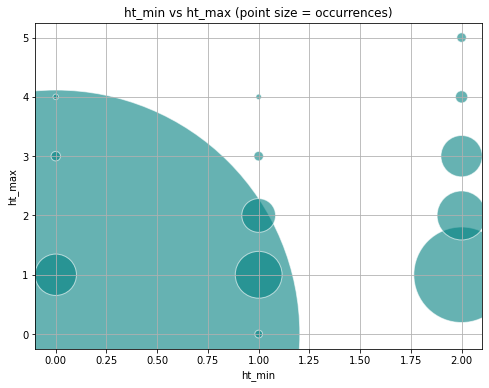

Flood_risk
None    23838
High     1173
Low      1005
Mid       927
Name: count, dtype: int64
ht_max  ht_min
0       0         23823
1000    2          1131
1       2           912
2       2           240
1       1           219
3       2           171
1       0           171
2       1           114
1000    1            78
        0            24
4       2            15
3       0             9
        1             9
5       2             9
0       1             6
1000    4             6
4       0             3
        1             3
Name: count, dtype: int64


In [44]:
plot_results(df_results,'H1',show_table=True)

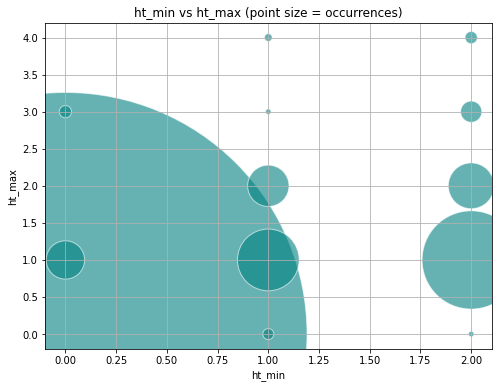

Flood_risk
None    23838
High     1173
Low      1005
Mid       927
Name: count, dtype: int64
ht_max  ht_min
0       0         23823
1000    2          1131
1       2           912
2       2           240
1       1           219
3       2           171
1       0           171
2       1           114
1000    1            78
        0            24
4       2            15
3       0             9
        1             9
5       2             9
0       1             6
1000    4             6
4       0             3
        1             3
Name: count, dtype: int64


In [45]:
plot_results(df_results,'H2',show_table=True)

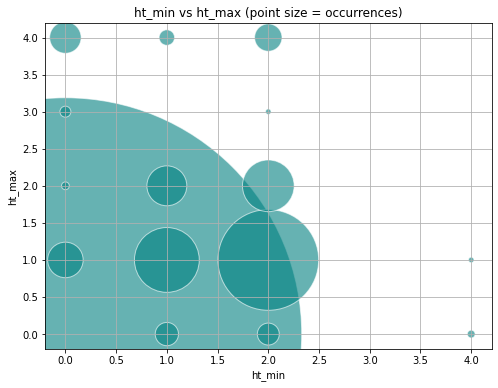

Flood_risk
None    23838
High     1173
Low      1005
Mid       927
Name: count, dtype: int64
ht_max  ht_min
0       0         23823
1000    2          1131
1       2           912
2       2           240
1       1           219
3       2           171
1       0           171
2       1           114
1000    1            78
        0            24
4       2            15
3       0             9
        1             9
5       2             9
0       1             6
1000    4             6
4       0             3
        1             3
Name: count, dtype: int64


In [46]:
plot_results(df_results,'H3',show_table=True)

# Score creation

For the creation of our score we will use our class of probability of occurence (see variable **Flood_risk**) and our predicted height (see variable **ht_min** and **ht_max**).
For this score we will use the classic form :

$$ Risk = P \times d$$

Where $d$ is a measure of our expected damage and $P$ is a measure of the probability of occurence of our event.

We will define our $P$ as the probability of occurence of our event for the running a year :

$$ P = \frac{1}{T} $$

Where $T$ is the **return period** in year.<br/> 
Our return periods are :

- **30 years** for the class **High**
- **100 to 300 years** for the class **Mid**
- **1000 years** for the class **Low**

Then we define our **damage measure** $d$ as :

$$ d = V_{assets} \times \frac{1}{1 + e^{1 - \frac{ht_{min} + ht_{max}}{2}}}$$

where $V_{assets}$ is the **value of our assets** and $ht_{min}$ and $ht_{max}$ are respectively our **minimum** and **maximum height**.

We consider here that we lose half of the value of our assets when our mean height reach 1 meter.<br/> 
That's probably overestimated but due to a lack of information on the impact of the height of a flood on the economical loss, we'll use this measure for our damages.

See [legifrance](https://www.legifrance.gouv.fr/loda/id/JORFTEXT000034438478) and [Flood Depth and Building Loss Analysis](https://www.researchgate.net/publication/393679584_Flood_Depth_and_Building_Loss_Analysis_A_Comprehensive_Study_on_Hazard_Impact_Assessment_and_Structural_Vulnerability) for information on the impact of height on the economical loss

> « Les parties de territoires susceptibles d'être affectées par des venues d'eau dangereuses. 
> Sont réputées dangereuses les venues d'eau telles que la **hauteur d'eau** atteint au moins **1 mètre** 
> ou le courant au moins 0,5 mètre par seconde »  
> — *Legifrance*